In [82]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.neighbors import KernelDensity
from datetime import datetime, date


In [272]:
# Read Robbery data, add month and year columns
fulldf = pd.read_pickle('../data/robbery-street.p')
fulldf['month'] = fulldf.date.apply(lambda x: x.month)
fulldf['year'] = fulldf.date.apply(lambda x: x.year)

# Join with weather
weather = pd.read_pickle(r"../data/noaa-weather-downtown-sf.p")
fulldf = fulldf.merge(weather,how="inner",left_on="date",right_on="DATE")

df = fulldf[fulldf.year < 2016]

count          25087
unique          4760
top       2008-04-28
freq              21
Name: date, dtype: object
count    25087.000000
mean        51.458153
std          4.486429
min         35.960000
25%         48.020000
50%         51.980000
75%         53.960000
max         68.000000
Name: TMIN, dtype: float64


## Yearly counts

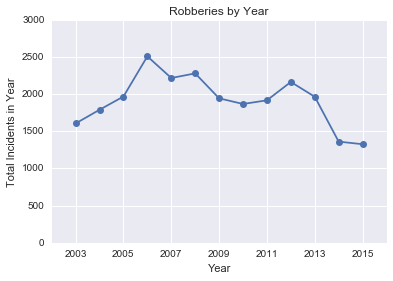

In [416]:
yearlytotal = df.year.value_counts().to_frame(name="count").sort_index()
yearlytotal['year'] = yearlytotal.index
plt.plot(yearlytotal['year'],yearlytotal['count'],'o-')
plt.xlabel('Year')
plt.ylabel('Total Incidents in Year')
plt.title('Robberies by Year')
plt.axis([2002, 2016, 0, 3000])
plt.xticks(range(2003,2016,2), range(2003,2016,2))
plt.savefig('plots/robbery-yearlycounts.png')
pass

## Aggregated by month

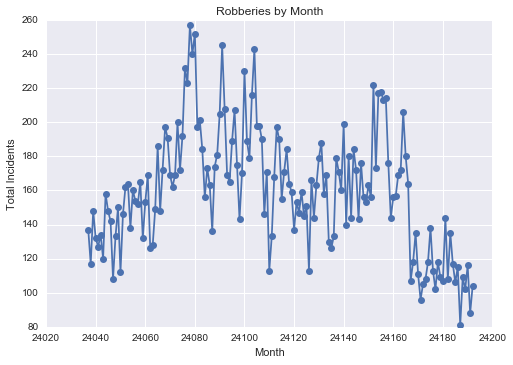

In [4]:
def monthyear2num(month,year):
    return year*12 + month

def num2monthyear(num):
    month = num % 12
    year = (num-month) / 12
    return "%.2d/%.2d" % (month,year)

groupbyyearmonth = df[['year','month']].groupby(by=['year','month']).size().to_frame(name="count")
groupbyyearmonth.reset_index(inplace=True)
groupbyyearmonth['monthyear'] = groupbyyearmonth.apply(lambda row: row['year']*12 + row['month'],axis=1)

plt.plot(groupbyyearmonth['monthyear'],groupbyyearmonth['count'],'o-')
plt.xlabel('Month')
plt.ylabel('Total Incidents')
plt.title('Robberies by Month')
pass

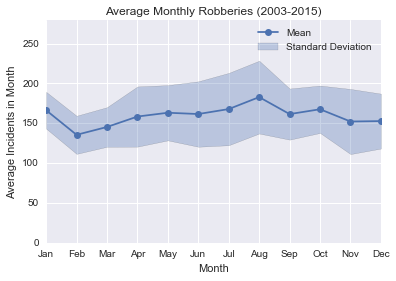

In [417]:
groupbymonth = groupbyyearmonth[['month','count']].groupby(by='month')
groupbymonth = groupbymonth['count'].agg({'sum' : sum, 'mean' : np.mean, 'std' : np.std})
plot_mean = plt.plot(groupbymonth.index,groupbymonth['mean'],'o-')
plot_std = plt.fill_between(groupbymonth.index, 
                 groupbymonth['mean']-groupbymonth['std'], 
                 groupbymonth['mean']+groupbymonth['std'],
                 alpha=.3)
plt.xlabel('Month')
plt.ylabel('Average Incidents in Month')
plt.title('Average Monthly Robberies (2003-2015)')
plt.legend(['Mean','Standard Deviation'])
plt.axis([1, 12, 0, 280])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.savefig('plots/robbery-monthlyaverage.png')
pass


## Aggregated by time of day

[0, 1440, 0, 0.002]

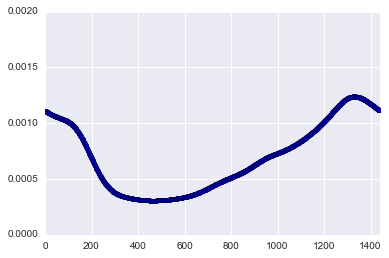

In [125]:
def scott_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 1.06*sigma*S.count()**(-0.2)

def silverman_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 0.9*sigma*S.count()**(-0.2)

class WrappedKDE:
    
    def __init__(self,S):
        # S is a pandas series
        self.bandwidth = silverman_bw(S)
        self.model = KernelDensity(bandwidth=self.bandwidth)
        return None
        
    def fit(self,data):
        self.model.fit(data.reshape(-1,1))
        return self
    
    def pdf(self,grid):
        grid = grid.reshape(-1,1)
        griddelta = grid[1]-grid[0]
        gridmax = grid[-1]+griddelta
        out = np.exp(self.model.score_samples(grid))
        out += np.exp(self.model.score_samples(grid-gridmax))
        out += np.exp(self.model.score_samples(grid+gridmax))
        return out

timekde = WrappedKDE(df.time.apply(time2num))
timekde.fit(df.time.apply(time2num))
plt.scatter(timegrid, timekde.pdf(timegrid))
plt.axis([0, 1440, 0, 0.002])

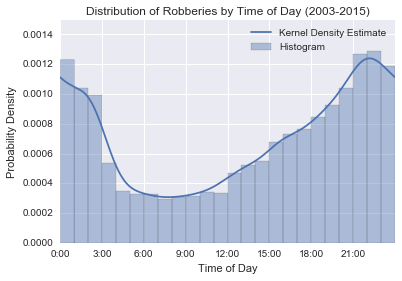

In [419]:
def time2num(t):
    ts = t.hour * 60 + t.minute
    return ts
hours = ['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00']
#plt.hist(df.time.apply(time2num),bins=24,normed=True,alpha=0.5)
sns.distplot(df.time.apply(time2num),kde = False,norm_hist=True,bins=24)
plt.plot(timegrid,timekde.pdf(timegrid),'-',color='#4C72B0')
plt.axis([0,1440,0,0.0015])
plt.xticks(range(0,1440,180), hours)

plt.xlabel('Time of Day')
plt.ylabel('Probability Density')
plt.title('Distribution of Robberies by Time of Day (2003-2015)')
plt.legend(['Kernel Density Estimate','Histogram'])
plt.savefig('plots/robbery-timeofdaydistribution.png')
pass

## Aggregation by day of week

   dayofweek       std   sum      mean  size    stderr  dayofweekno
1     Monday  2.824411  3556  5.299553   671  0.109035            1
5    Tuesday  2.759771  3468  5.199400   667  0.106859            2
6  Wednesday  2.727984  3463  5.176383   669  0.105470            3
4   Thursday  2.586955  3438  5.154423   667  0.100167            4
0     Friday  2.608878  3489  5.223054   668  0.100941            5
2   Saturday  2.704624  3757  5.582467   673  0.104256            6
3     Sunday  2.718939  3718  5.524517   673  0.104807            7


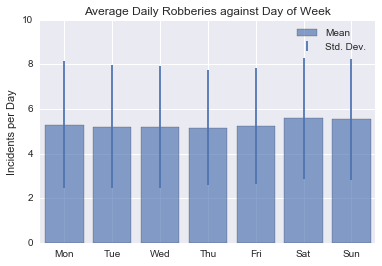

In [431]:
groupbydate = df[['date','dayofweek']].groupby(by=['date','dayofweek']).size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
groupbyweekday = groupbydate.groupby(by='dayofweek')
#groupbyweekday = groupbyweekday['count'].agg(['size','sum','mean','std'])
groupbyweekday = groupbyweekday['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyweekday['stderr'] = groupbyweekday.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
groupbyweekday.reset_index(inplace=True)

weekdayno ={ 
    u'Monday' : 1,
    u'Tuesday' : 2,
    u'Wednesday' : 3,
    u'Thursday' : 4,
    u'Friday' : 5,
    u'Saturday' : 6,
    u'Sunday' : 7
}
groupbyweekday['dayofweekno'] = groupbyweekday['dayofweek'].apply(lambda x: weekdayno[x])
groupbyweekday.sort_values(by='dayofweekno',inplace=True)
print groupbyweekday

weekdaylabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

p = plt.bar(left=groupbyweekday['dayofweekno'].as_matrix(),
           height=groupbyweekday['mean'].as_matrix(),
           width=0.8,
           tick_label=weekdaylabels,
           align='center',
           yerr = groupbyweekday['std'],
           alpha=0.66)
plt.axis([0.5,7.5,0,10])
plt.title('Average Daily Robberies against Day of Week')
plt.ylabel('Incidents per Day')
plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='upper right')
plt.savefig('plots/robbery-dayofweekaverage.png')
pass

## Aggregation by spatial location

In [127]:
def silverman_bwxy(df):
    count = df['x'].count()
    stdx = df['x'].std()
    stdy = df['y'].std()
    iqrx = np.subtract(*np.percentile(df['x'], [75, 25]))
    iqry = np.subtract(*np.percentile(df['y'], [75, 25]))
    sigma = min(stdx,stdy,iqrx,iqry)
    return 0.9*sigma*count**(-0.2)

spacekde = KernelDensity(bandwidth = silverman_bwxy(df[['x','y']]),metric='haversine')
spacekde.fit(df[['x','y']])


KernelDensity(algorithm='auto', atol=0, bandwidth=0.0026073070785577511,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='haversine', metric_params=None, rtol=0)

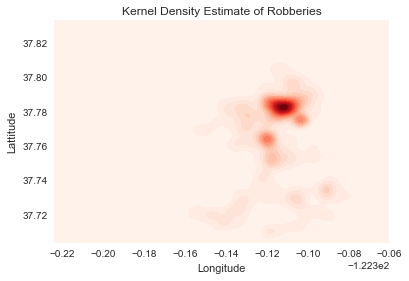

In [421]:
xmin = -122.5237517
xmax = -122.3602017
ymin = 37.7040012
ymax = 37.8341382

xv, yv = np.meshgrid(np.linspace(xmin,xmax,num=200),np.linspace(ymin,ymax,num=200))

X_grid = np.vstack([xv.ravel(), yv.ravel()]).transpose()



Z = np.exp(spacekde.score_samples(X_grid))
Z = Z.reshape(xv.shape)

levels = np.linspace(Z.min(), Z.max(), 25)
plt.contourf(xv, yv, Z, levels=levels, cmap=plt.cm.Reds)
plt.title('Kernel Density Estimate of Robberies')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
plt.savefig('plots/robbery-spatialkdeheatmap.png')

In [145]:
def toheatarray(X,Z):
    return [[point[0], point[1], point[2]] for point in zip(X[:,0],X[:,1],Z)]

## Aggregation by precipitation

               std      sum      mean  size    stderr
PRCP                                                 
[0, 5)    2.718586  22987.0  5.352037  4295  0.041482
[5, 10)   2.503154    768.0  4.598802   167  0.193700
[10, 15)  2.582517    395.0  4.702381    84  0.281776
[15, 20)  2.563977    281.0  5.734694    49  0.366282
[20, 25)  2.848882    159.0  5.129032    31  0.511674
[25, 30)  2.197737    131.0  4.517241    29  0.408110
[30, 35)  2.769536     68.0  4.857143    14  0.740190
[35, 40)  3.577709     38.0  7.600000     5  1.600000
[40, 45)       NaN      6.0  6.000000     1       NaN
[45, 50)  1.000000     15.0  5.000000     3  0.577350
[50, 55)  1.632993     20.0  5.000000     4  0.816497
[55, 60)  1.414214      8.0  4.000000     2  1.000000
[60, 65)       NaN      4.0  4.000000     1       NaN
[65, 70)       NaN      3.0  3.000000     1       NaN
[70, 75)       NaN      NaN       NaN     0       NaN
[75, 80)       NaN      NaN       NaN     0       NaN
[80, 85)       NaN      4.0 

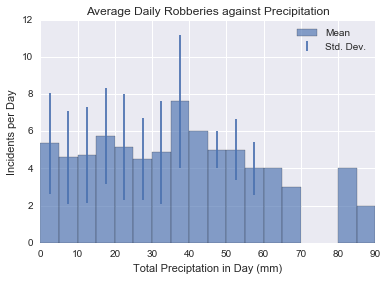

In [422]:
groupbydate = df.groupby(by='date').size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
groupbydate = groupbydate.merge(weather,how="inner",left_on="date",right_on="DATE")
groupbyprcp = groupbydate.groupby(pd.cut(groupbydate.PRCP,bins=range(0,91,5),right=False))
groupbyprcp = groupbyprcp['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyprcp['stderr'] = groupbyprcp.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbyprcp

p = plt.bar(left=np.arange(0,90,5),
           height=groupbyprcp['mean'].as_matrix(),
           width=5,
           yerr = groupbyprcp['std'],
           alpha=0.66)
plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily Robberies against Precipitation')
plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='upper right')
plt.axis([0,90,0,12])
plt.savefig('plots/robbery-precipaverage.png')


## Aggregation by TMAX

In [223]:
def celsius2fahrenheit(T):
    return T * 1.8 + 32

In [363]:
df.TMAX.apply(celsius2fahrenheit).describe()

count    24889.000000
mean        64.259115
std          7.409489
min         44.060000
25%         59.000000
50%         62.960000
75%         68.000000
max         98.060000
Name: TMAX, dtype: float64

                std   sum      mean  size    stderr
TMAX                                               
[40, 45)   0.577350    11  3.666667     3  0.333333
[45, 50)   2.666430   172  5.212121    33  0.464166
[50, 55)   2.542331  1380  5.111111   270  0.154721
[55, 60)   2.709085  4785  5.184182   923  0.089171
[60, 65)   2.625811  9385  5.281373  1777  0.062290
[65, 70)   2.849126  5349  5.392137   992  0.090460
[70, 75)   2.843059  1596  5.580420   286  0.168114
[75, 80)   2.748418  1120  5.463415   205  0.191958
[80, 85)   2.854492   672  5.793103   116  0.265033
[85, 90)   2.538982   285  5.089286    56  0.339286
[90, 95)   1.916381    89  4.684211    19  0.439648
[95, 100)  2.924649    45  5.625000     8  1.034020


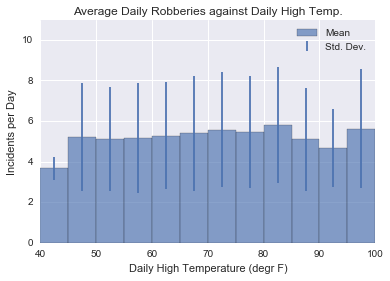

In [423]:
groupbydate = df.groupby(by='date').size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
groupbydate = groupbydate.merge(weather,how="inner",left_on="date",right_on="DATE")
groupbydate['TMAX'] = groupbydate.TMAX.apply(celsius2fahrenheit)
groupbytmax = groupbydate.groupby(pd.cut(groupbydate.TMAX,bins=range(40,101,5),right=False))
groupbytmax = groupbytmax['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmax['stderr'] = groupbytmax.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbytmax


p = plt.bar(left=np.arange(40,100,5),
           height=groupbytmax['mean'].as_matrix(),
           width=5,
           yerr = groupbytmax['std'],
           alpha=0.66)
plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily Robberies against Daily High Temp.')
plt.legend([p,p.errorbar],['Mean','Std. Dev.'])
plt.axis([40,100,0,11])
plt.savefig('plots/robbery-tmaxaverage.png')
pass

## Aggregation by TMIN

In [260]:
df.TMIN.apply(celsius2fahrenheit).describe()

count    24889.000000
mean        51.465385
std          4.494721
min         35.960000
25%         48.020000
50%         51.980000
75%         53.960000
max         68.000000
Name: TMIN, dtype: float64

               std    sum      mean  size    stderr
TMIN                                               
[35, 40)  2.268953    275  5.000000    55  0.136823
[40, 45)  2.521988   2124  5.118072   415  0.054722
[45, 50)  2.664014   5421  5.187560  1045  0.036182
[50, 55)  2.659668  11051  5.330921  2073  0.025300
[55, 60)  2.954433   5237  5.571277   940  0.040826
[60, 65)  2.579064    755  4.839744   156  0.093862
[65, 70)  3.872983     26  6.500000     4  0.759555


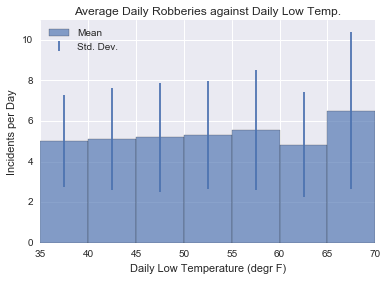

In [424]:
groupbydate = df.groupby(by='date').size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
groupbydate = groupbydate.merge(weather,how="inner",left_on="date",right_on="DATE")
groupbydate['TMIN'] = groupbydate.TMIN.apply(celsius2fahrenheit)
groupbytmin = groupbydate.groupby(pd.cut(groupbydate.TMIN,bins=range(35,71,5),right=False))
groupbytmin = groupbytmin['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmin['stderr'] = groupbytmin.apply(lambda row: row['std']/np.sqrt(row['sum']),axis=1)
print groupbytmin
p = plt.bar(left=np.arange(35,70,5),
           height=groupbytmin['mean'].as_matrix(),
           width=5,
           yerr = groupbytmin['std'],
           alpha=0.66)
plt.xlabel('Daily Low Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily Robberies against Daily Low Temp.')
plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='best')
plt.axis([35,70,0,11])
plt.savefig('plots/robbery-tminaverage.png')
pass